# 국민건강보험 데이터

국민건강보험 데이터는 [국민건강보험 공공데이터 개방서비스](http://nhiss.nhis.or.kr/op/it/index.do)에서 제공되고 있다. 개인식별정보는 제외되었으며 표번은 매년 100만명의 무작위추출(Random Sampling)되었다. 자료는 매년 12월 2년 전 데이터를 추가하는 방식으로 직전년도 데이터는 추가되지 않는다. 여기서는 가장 최근 자료인 2015년도 데이터를 분석한다.

In [34]:
# Load Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Settings
%matplotlib inline
sns.set(font="NanumGothic")
pbar = ProgressBar()
pbar.register()

국민건강보험에서 데이터는 세가지 형태로 제공된다.
1. 진료내역정보
2. 의약품처방정보
3. 건강검진정보

본 분석에서 진료정보는 `gj`, 진료내역정보는 `t20`, 의약품처방정보는 `t60`로 다루어진다.

### Data Loading

국민건강보험의 데이터는 진료내역정보(약 1,120만개), 의약품처방정보(약 3,000만개), 건강검진정보(100만개)로 방대한 데이터가 포함되어있다. 따라서 이를 다루기 위해서는 out-of-core computation이 필요하다. 따라서 여기서는 dask를 통해 데이터를 다루게 된다.

In [2]:
# Load Data
gj = dd.read_csv('./data/NHIS_OPEN_GJ_2015.CSV')  # Medical Examination Data
t20 = dd.read_csv('./data/NHIS_OPEN_T20_2015.CSV')  # Treatment Data
t60_part1 = dd.read_csv('./data/NHIS_OPEN_T60_2015_part1.CSV')
t60_part2 = dd.read_csv('./data/NHIS_OPEN_T60_2015_part2.CSV')
t60 = t60_part1.append(t60_part2)  # Prescription Data

# 데이터 정보

## 진료내역정보 (t20)

[FEATURE 설명]

## 주요질병정보 분석

질병의 종류만으로 종이 넘으므로 본 분석에서는 주상병의 경우 가장 빈도가 높은 10개, 부상병의 경우 빈도가 높은 20개를 살펴보도록 할 것이다.

In [12]:
# Count TOP 10 Main Sick
main_sick_count = t20.MAIN_SICK.value_counts().compute()
top10_main_sick = main_sick_count[:10]

# t20 table confined to top 10 main sick
t20_top10_sick = t20[t20.MAIN_SICK.isin(top10_main_sick.index)].compute()

[########################################] | 100% Completed | 10.1s
[########################################] | 100% Completed |  8.2s


## 상위 10개 주상병의 성별에 따른 countplot

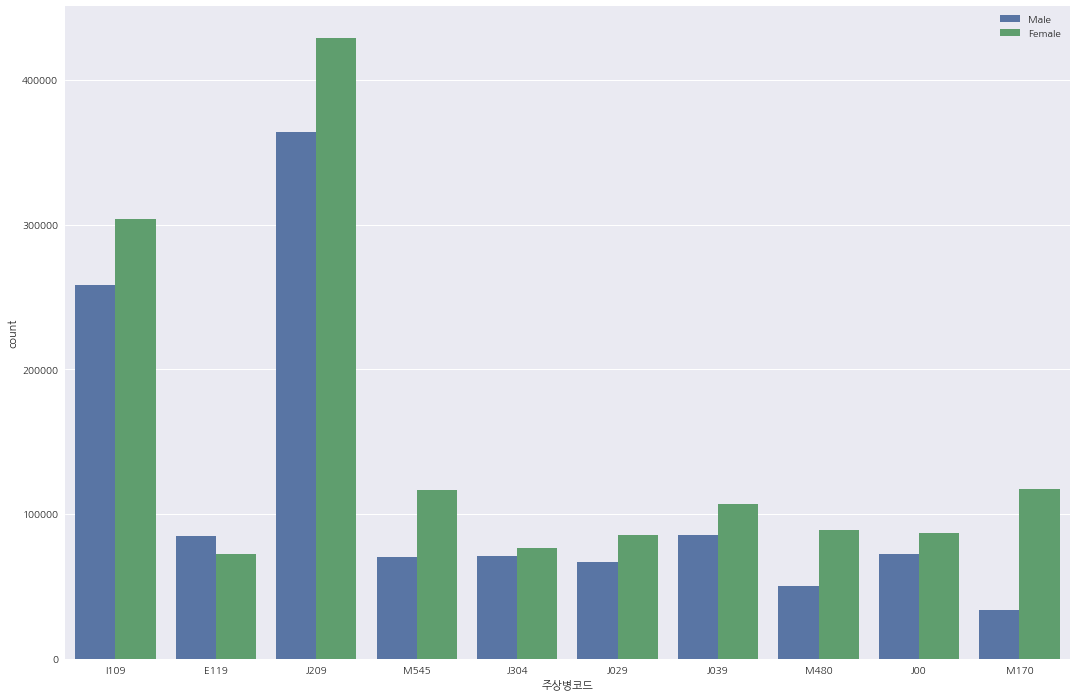

In [22]:
# MAIN_SICK, SEX / COUNT
plt.figure(figsize=(18,12))
sns.countplot(x="MAIN_SICK", hue="SEX", data=t20_top10_sick)
plt.legend(["Male", "Female"])
plt.xlabel("주상병코드")
plt.show()

## 상위 10개 주상병에 대한 지급 보험금

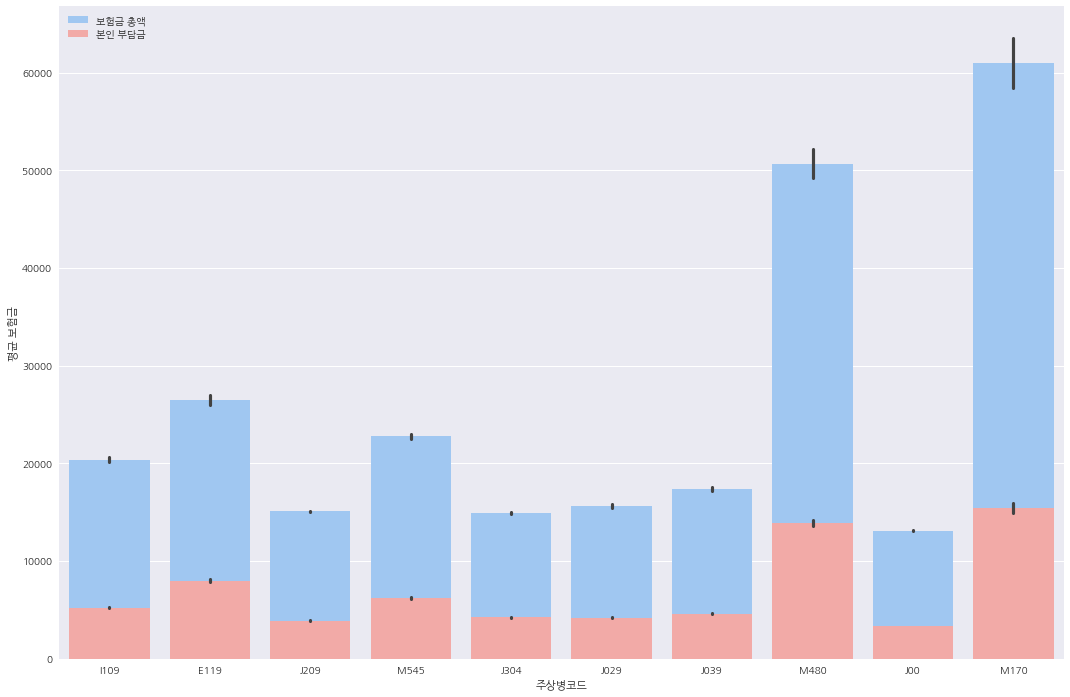

In [21]:
# MAIN_SICK / Insured CLAIM
plt.figure(figsize=(18,12))
sns.set_color_codes("pastel")
sns.barplot(x="MAIN_SICK", y="EDEC_TRAMT", data=t20_top10_sick,
            label="보험금 총액", color="b")
sns.barplot(x="MAIN_SICK", y="EDEC_SBRDN_AMT", data=t20_top10_sick,
            label="본인 부담금", color="r")
plt.legend()
plt.xlabel("주상병코드")
plt.ylabel("평균 보험금")
plt.show()

## 주상병과 부상병관의 상관관계

In [17]:
# MAIN_SICK, SUB_SICK / HEATMAP
t20_top10_sick_with_sub_sick = t20_top10_sick.SUB_SICK.value_counts()
t20_top10_sick_with_sub_sick = t20_top10_sick_with_sub_sick[:20]
t20_main_sub_sick = t20_top10_sick[t20_top10_sick.isin(t20_top10_sick_with_sub_sick.index)]

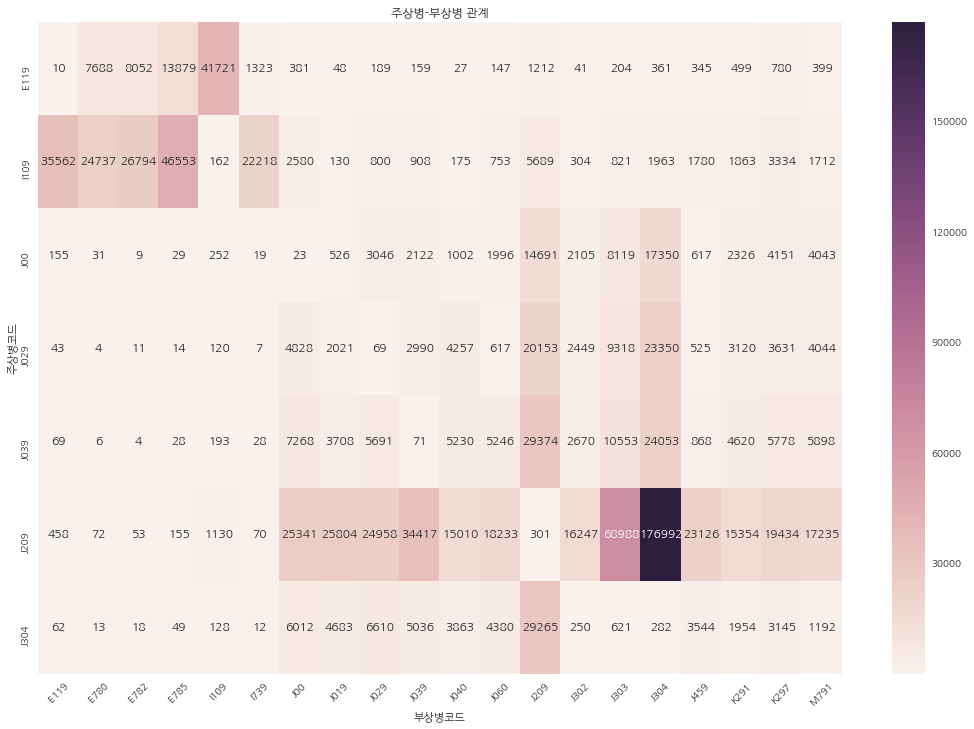

In [35]:
# HEATMAP
plt.figure(figsize=(18,12))
main_sub_sick_size = t20_main_sub_sick.pivot_table(index="MAIN_SICK",
                                                   columns="SUB_SICK",
                                                   aggfunc="size")
sns.heatmap(main_sub_sick_size, annot=True, fmt="d")
plt.xticks(rotation=45)
plt.title("주상병-부상병 관계")
plt.xlabel("부상병코드")
plt.ylabel("주상병코드")
plt.show()